In [ ]:
# Core NLP / ML requirements
!pip install datasets transformers accelerate peft torch matplotlib seaborn scikit-learn textstat nltk pandas numpy
!pip install bitsandbytes
!pip install requests

# Japanese tokenization requirements (must be BEFORE you load Japanese models!)
!pip install fugashi ipadic unidic-lite


Using device: cuda
Loading WRIME Japanese dataset...
WRIME データセットを読み込み中...
Dataset downloaded successfully to /tmp/wrime-ver1.tsv
Original dataset shape: (43200, 44)
Columns: ['Sentence', 'UserID', 'Datetime', 'Train/Dev/Test', 'Writer_Joy', 'Writer_Sadness', 'Writer_Anticipation', 'Writer_Surprise', 'Writer_Anger', 'Writer_Fear', 'Writer_Disgust', 'Writer_Trust', 'Reader1_Joy', 'Reader1_Sadness', 'Reader1_Anticipation', 'Reader1_Surprise', 'Reader1_Anger', 'Reader1_Fear', 'Reader1_Disgust', 'Reader1_Trust', 'Reader2_Joy', 'Reader2_Sadness', 'Reader2_Anticipation', 'Reader2_Surprise', 'Reader2_Anger', 'Reader2_Fear', 'Reader2_Disgust', 'Reader2_Trust', 'Reader3_Joy', 'Reader3_Sadness', 'Reader3_Anticipation', 'Reader3_Surprise', 'Reader3_Anger', 'Reader3_Fear', 'Reader3_Disgust', 'Reader3_Trust', 'Avg. Readers_Joy', 'Avg. Readers_Sadness', 'Avg. Readers_Anticipation', 'Avg. Readers_Surprise', 'Avg. Readers_Anger', 'Avg. Readers_Fear', 'Avg. Readers_Disgust', 'Avg. Readers_Trust']
Befor

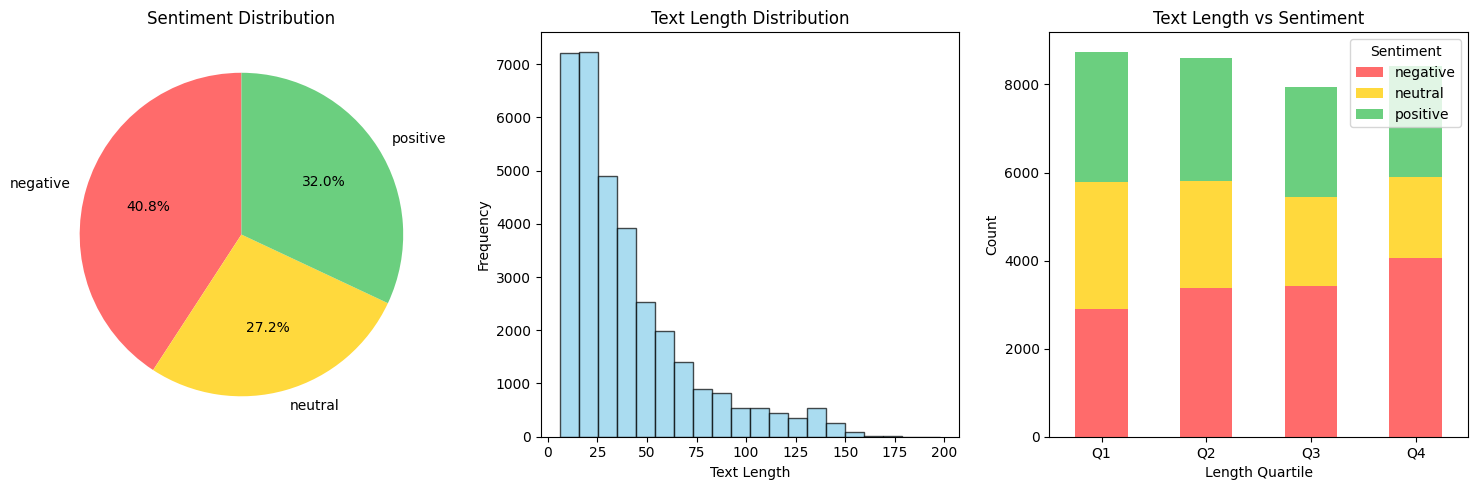

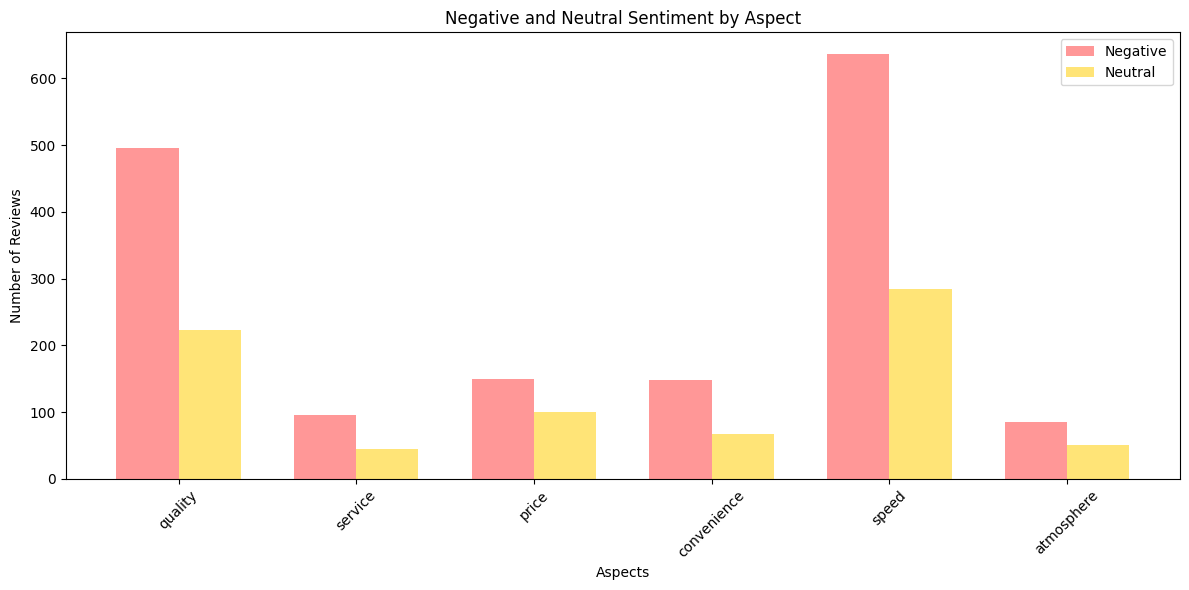

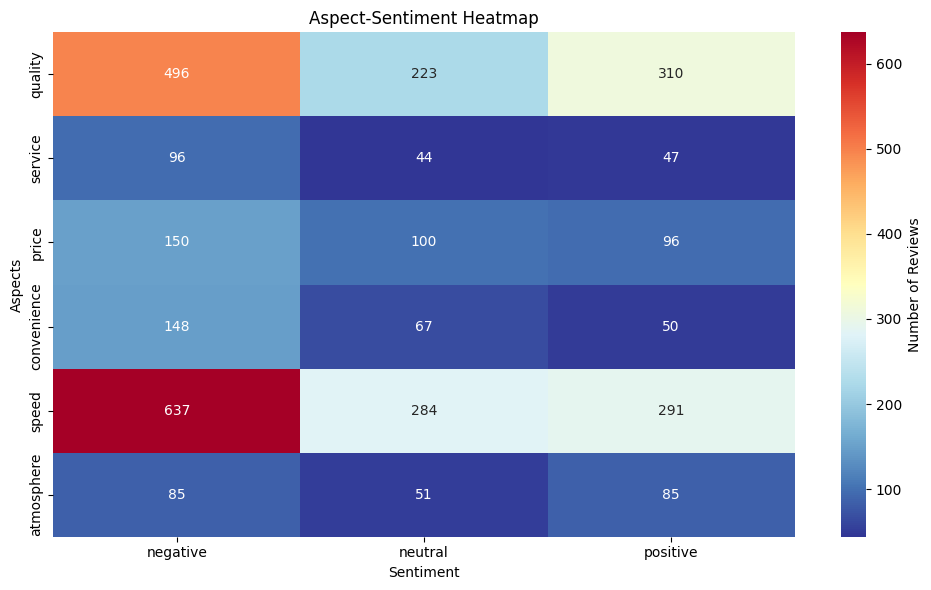


=== BUSINESS INSIGHTS & RECOMMENDATIONS ===
• QUALITY: 1029 mentions, 48.2% negative, 21.7% neutral
• SERVICE: 187 mentions, 51.3% negative, 23.5% neutral
• PRICE: 346 mentions, 43.4% negative, 28.9% neutral
• CONVENIENCE: 265 mentions, 55.8% negative, 25.3% neutral
• SPEED: 1212 mentions, 52.6% negative, 23.4% neutral
• ATMOSPHERE: 221 mentions, 38.5% negative, 23.1% neutral
Loading model and tokenizer: cl-tohoku/bert-base-japanese-whole-word-masking


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cl-tohoku/bert-base-japanese-whole-word-masking and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 297,219 || all params: 110,916,870 || trainable%: 0.2680


Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/8425 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Dataset preparation completed
Train dataset size: 3000
Test dataset size: 8425
Starting model training with LoRA...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.111300,1.087508,0.407834,0.394823,0.393455,0.407834
2,1.077600,0.974760,0.554540,0.496611,0.534424,0.554540
3,0.936100,0.877075,0.606647,0.598977,0.594761,0.606647
4,0.876800,0.852465,0.618160,0.613454,0.611890,0.618160
5,0.858800,0.839217,0.628131,0.623182,0.620802,0.628131
6,0.787800,0.832456,0.631929,0.623757,0.621265,0.631929
7,0.796600,0.828955,0.635371,0.636219,0.637249,0.635371
8,0.794200,0.824578,0.637270,0.636046,0.635459,0.637270
9,0.759800,0.826325,0.637151,0.637118,0.637590,0.637151
10,0.773300,0.823880,0.640356,0.639708,0.639168,0.640356



=== Test Results (Hold-out Set) ===


Test Accuracy: 0.6404
Test F1: 0.6397
Test Precision: 0.6392
Test Recall: 0.6404

=== Detailed Classification Report ===
              precision    recall  f1-score   support

    negative       0.72      0.73      0.73      3438
     neutral       0.48      0.47      0.48      2293
    positive       0.68      0.67      0.67      2694

    accuracy                           0.64      8425
   macro avg       0.62      0.62      0.62      8425
weighted avg       0.64      0.64      0.64      8425



<Figure size 800x600 with 0 Axes>

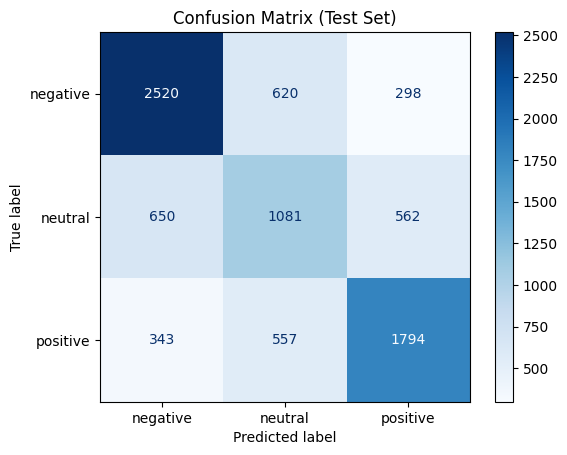


Pipeline completed!


In [4]:
# !pip install fugashi ipadic
# !pip install datasets transformers accelerate torch matplotlib seaborn scikit-learn textstat nltk pandas numpy requests peft

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings, re, torch, gc, random, os, requests
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_recall_fscore_support, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    TrainingArguments, Trainer, DataCollatorWithPadding
)
from datasets import Dataset
from peft import LoraConfig, get_peft_model, TaskType

warnings.filterwarnings('ignore')

# --- Ensure VADER ---
try:
    nltk.data.find('vader_lexicon')
except LookupError:
    nltk.download('vader_lexicon', quiet=True)

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

class BusinessInsightExtractor:
    def __init__(self):
        self.aspects = {
            'quality': ['品質', '質', '良い', '悪い', '高品質', '低品質', 'クオリティ'],
            'service': ['サービス', '対応', '接客', '親切', '丁寧', '態度'],
            'price': ['価格', '値段', '料金', '安い', '高い', 'コスト', '費用'],
            'convenience': ['便利', '不便', '簡単', '難しい', '使いやすい', '使いにくい'],
            'speed': ['速い', '遅い', '早い', 'スピード', '迅速', '時間'],
            'atmosphere': ['雰囲気', '環境', '空間', '居心地', '快適', '不快']
        }
    
    def generate_business_recommendations(self, df):
        print("\n=== BUSINESS INSIGHTS & RECOMMENDATIONS ===")
        for aspect in self.aspects.keys():
            aspect_col = f'aspect_{aspect}'
            if aspect_col in df.columns:
                aspect_mentions = df[df[aspect_col] == 1].shape[0]
                negative_mentions = df[(df[aspect_col] == 1) & (df['sentiment'] == 'negative')].shape[0]
                neutral_mentions = df[(df[aspect_col] == 1) & (df['sentiment'] == 'neutral')].shape[0]
                if aspect_mentions > 0:
                    negative_rate = negative_mentions / aspect_mentions * 100
                    neutral_rate = neutral_mentions / aspect_mentions * 100
                    print(f"• {aspect.upper()}: {aspect_mentions} mentions, {negative_rate:.1f}% negative, {neutral_rate:.1f}% neutral")
        return {"status": "completed"}

def executive_summary(df):
    print("\n=== EXECUTIVE SUMMARY ===")
    total_reviews = len(df)
    sentiment_dist = df['sentiment'].value_counts(normalize=True) * 100
    print(f"Total Reviews Analyzed: {total_reviews:,}")
    print("Sentiment Distribution:")
    for sentiment, pct in sentiment_dist.items():
        print(f"  • {sentiment.capitalize()}: {pct:.1f}%")

def plot_overall_sentiment(df):
    plt.figure(figsize=(15, 5))
    sentiment_order = ['negative', 'neutral', 'positive']
    colors = {'negative': '#ff6b6b', 'neutral': '#ffd93d', 'positive': '#6bcf7f'}
    
    plt.subplot(1, 3, 1)
    sentiment_counts = df['sentiment'].value_counts().reindex(sentiment_order, fill_value=0)
    pie_colors = [colors[s] for s in sentiment_counts.index]
    plt.pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.1f%%',
            colors=pie_colors, startangle=90)
    plt.title('Sentiment Distribution')
    
    plt.subplot(1, 3, 2)
    plt.hist(df['text_length'], bins=20, color='skyblue', alpha=0.7, edgecolor='black')
    plt.xlabel('Text Length')
    plt.ylabel('Frequency')
    plt.title('Text Length Distribution')
    
    plt.subplot(1, 3, 3)
    df['length_quartile'] = pd.qcut(df['text_length'], 4, labels=['Q1', 'Q2', 'Q3', 'Q4'])
    length_sentiment = df.groupby(['length_quartile', 'sentiment']).size().unstack(fill_value=0)
    for s in sentiment_order:
        if s not in length_sentiment.columns:
            length_sentiment[s] = 0
    length_sentiment = length_sentiment[sentiment_order]
    bar_colors = [colors[s] for s in sentiment_order]
    length_sentiment.plot(kind='bar', stacked=True, color=bar_colors, ax=plt.gca())
    plt.title('Text Length vs Sentiment')
    plt.xlabel('Length Quartile')
    plt.ylabel('Count')
    plt.legend(title='Sentiment')
    plt.xticks(rotation=0)
    
    plt.tight_layout()
    plt.show()

def plot_negative_aspect_breakdown(df):
    aspects = list(df.columns[df.columns.str.startswith('aspect_')].str.replace('aspect_', ''))
    negative_counts, neutral_counts = [], []
    
    for aspect in aspects:
        aspect_col = f'aspect_{aspect}'
        if aspect_col in df.columns:
            neg_count = df[(df[aspect_col] == 1) & (df['sentiment'] == 'negative')].shape[0]
            neu_count = df[(df[aspect_col] == 1) & (df['sentiment'] == 'neutral')].shape[0]
            negative_counts.append(neg_count)
            neutral_counts.append(neu_count)
        else:
            negative_counts.append(0)
            neutral_counts.append(0)
    
    if aspects and any(negative_counts + neutral_counts):
        plt.figure(figsize=(12, 6))
        x = np.arange(len(aspects))
        width = 0.35
        plt.bar(x - width/2, negative_counts, width, label='Negative', color='#ff6b6b', alpha=0.7)
        plt.bar(x + width/2, neutral_counts, width, label='Neutral', color='#ffd93d', alpha=0.7)
        plt.title('Negative and Neutral Sentiment by Aspect')
        plt.xlabel('Aspects')
        plt.ylabel('Number of Reviews')
        plt.xticks(x, aspects, rotation=45)
        plt.legend()
        plt.tight_layout()
        plt.show()

def plot_aspect_sentiment_heatmap(df):
    aspects = list(df.columns[df.columns.str.startswith('aspect_')].str.replace('aspect_', ''))
    sentiments = ['negative', 'neutral', 'positive']
    
    if not aspects:
        print("No aspects found for heatmap visualization")
        return
    
    heatmap_data = []
    for aspect in aspects:
        aspect_col = f'aspect_{aspect}'
        row = []
        for sentiment in sentiments:
            if aspect_col in df.columns:
                count = df[(df[aspect_col] == 1) & (df['sentiment'] == sentiment)].shape[0]
                row.append(count)
            else:
                row.append(0)
        heatmap_data.append(row)
    
    if any(any(row) for row in heatmap_data):
        plt.figure(figsize=(10, 6))
        sns.heatmap(heatmap_data,
                    xticklabels=sentiments,
                    yticklabels=aspects,
                    annot=True,
                    fmt='d',
                    cmap='RdYlBu_r',
                    cbar_kws={'label': 'Number of Reviews'})
        plt.title('Aspect-Sentiment Heatmap')
        plt.xlabel('Sentiment')
        plt.ylabel('Aspects')
        plt.tight_layout()
        plt.show()

class ABSALLMLoRAPipeline:
    def __init__(self, model_name="cl-tohoku/bert-base-japanese-whole-word-masking"):
        self.label_encoder = LabelEncoder()
        self.insight_extractor = BusinessInsightExtractor()
        self.sia = SentimentIntensityAnalyzer()
        self.model_name = model_name
        self.tokenizer = None
        self.model = None

    def download_wrime_dataset(self):
        print("WRIME データセットを読み込み中...")
        wrime_url = "https://raw.githubusercontent.com/ids-cv/wrime/refs/heads/master/wrime-ver1.tsv"
        wrime_path = "/tmp/wrime-ver1.tsv"
        try:
            response = requests.get(wrime_url, timeout=30)
            response.raise_for_status()
            with open(wrime_path, 'w', encoding='utf-8') as f:
                f.write(response.text)
            print(f"Dataset downloaded successfully to {wrime_path}")
            return wrime_path
        except Exception as e:
            print(f"Failed to download WRIME dataset: {e}")
            raise Exception("Cannot proceed without WRIME dataset")

    def load_and_preprocess_data(self):
        print("Loading WRIME Japanese dataset...")
        dataset_path = self.download_wrime_dataset()
        
        # Load WRIME dataset
        df = pd.read_csv(dataset_path, sep='\t', encoding='utf-8')
        print(f"Original dataset shape: {df.shape}")
        print(f"Columns: {df.columns.tolist()}")
        
        # Handle text column
        if 'Sentence' in df.columns:
            df['review_text'] = df['Sentence']
        elif 'sentence' in df.columns:
            df['review_text'] = df['sentence']
        else:
            text_cols = [col for col in df.columns if any(keyword in col.lower() for keyword in ['text', 'sentence', 'content'])]
            if text_cols:
                df['review_text'] = df[text_cols[0]]
            else:
                raise ValueError("No text column found in dataset")
        
        # Clean data - remove NaN and empty strings
        print(f"Before cleaning: {len(df)} samples")
        df = df.dropna(subset=['review_text'])
        df = df[df['review_text'].astype(str).str.strip() != '']
        df = df[df['review_text'].astype(str).str.len() > 5]  # Remove very short texts
        print(f"After cleaning: {len(df)} samples")
        
        # Shuffle data
        df = df.sample(frac=1, random_state=42).reset_index(drop=True)
        
        # Create sentiment labels based on WRIME emotion scores with improved logic
        emotion_cols = ['Avg. Readers_Joy', 'Avg. Readers_Sadness', 'Avg. Readers_Anger', 
                       'Avg. Readers_Fear', 'Avg. Readers_Surprise', 'Avg. Readers_Disgust']
        
        # Convert to numeric and handle NaN values
        for col in emotion_cols:
            if col in df.columns:
                df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)
            else:
                df[col] = 0
        
        # Calculate composite scores
        df['positive_score'] = df['Avg. Readers_Joy'] + (df['Avg. Readers_Surprise'] * 0.5)
        df['negative_score'] = (df['Avg. Readers_Sadness'] + df['Avg. Readers_Anger'] + 
                              df['Avg. Readers_Fear'] + df['Avg. Readers_Disgust'])
        
        # Determine sentiment with improved thresholds
        def determine_sentiment(row):
            pos_score = row['positive_score']
            neg_score = row['negative_score']
            total_score = pos_score + neg_score
            
            # If total score is very low, consider it neutral
            if total_score < 0.5:
                return 'neutral'
            
            # Clear positive/negative with significant difference
            if pos_score > neg_score and pos_score > 0.8:
                return 'positive'
            elif neg_score > pos_score and neg_score > 0.8:
                return 'negative'
            else:
                return 'neutral'
        
        df['sentiment'] = df.apply(determine_sentiment, axis=1)
        
        # Remove samples with invalid sentiment
        df = df.dropna(subset=['sentiment'])
        df = df[df['sentiment'].isin(['positive', 'negative', 'neutral'])]
        
        print(f"Final dataset shape: {df.shape}")
        print("Sentiment distribution:")
        sentiment_counts = df['sentiment'].value_counts()
        print(sentiment_counts)
        print(sentiment_counts / len(df) * 100)
        
        # Ensure we have sufficient samples for each class
        min_samples_per_class = 50
        if (sentiment_counts < min_samples_per_class).any():
            print("Warning: Some sentiment classes have very few samples")
            # Filter to keep only classes with sufficient samples
            valid_sentiments = sentiment_counts[sentiment_counts >= min_samples_per_class].index.tolist()
            if len(valid_sentiments) < 2:
                raise ValueError("Not enough samples for training. Need at least 2 classes with 50+ samples each.")
            df = df[df['sentiment'].isin(valid_sentiments)]
            print(f"Filtered to {len(df)} samples with valid sentiments: {valid_sentiments}")
        
        # Split into train/test (80/20) with stratification
        train_df, test_df = train_test_split(
            df,
            test_size=0.2,
            random_state=42,
            stratify=df['sentiment']
        )
        
        print(f"Train set: {len(train_df)} samples")
        print(f"Test set: {len(test_df)} samples")
        print("Train sentiment distribution:")
        print(train_df['sentiment'].value_counts())
        print("Test sentiment distribution:")
        print(test_df['sentiment'].value_counts())
        
        return train_df, test_df

    def extract_comprehensive_features(self, df):
        """Extract features from text data"""
        aspects = self.insight_extractor.aspects
        
        # Extract aspect-based features
        for aspect, keywords in aspects.items():
            pattern = '|'.join([re.escape(kw) for kw in keywords])
            df[f'aspect_{aspect}'] = df['review_text'].str.contains(pattern, na=False, regex=True).astype(int)
        
        # Extract text statistics
        df['text_length'] = df['review_text'].str.len()
        df['word_count'] = df['review_text'].str.split().str.len()
        df['sentence_count'] = df['review_text'].str.count(r'[。！？]+') + 1
        df['avg_word_length'] = df['review_text'].apply(
            lambda x: np.mean([len(word) for word in str(x).split()]) if str(x).split() else 0
        )
        
        # VADER sentiment scores
        df['vader_compound'] = df['review_text'].apply(
            lambda x: self.sia.polarity_scores(str(x))['compound']
        )
        
        return df

    def prepare_datasets(self, train_df, test_df):
        """Prepare datasets for training"""
        def tokenize_function(examples):
            return self.tokenizer(
                examples['review_text'],
                truncation=True,
                padding=False,  # Don't pad here, let data collator handle it
                max_length=256,  # Increased max length
                return_tensors=None
            )
        
        # Prepare training data
        train_labels = self.label_encoder.transform(train_df['sentiment'])
        train_data = {'review_text': train_df['review_text'].tolist(), 'labels': train_labels.tolist()}
        train_dataset = Dataset.from_dict(train_data)
        train_dataset = train_dataset.map(tokenize_function, batched=True, remove_columns=['review_text'])

        # Prepare test data
        test_labels = self.label_encoder.transform(test_df['sentiment'])
        test_data = {'review_text': test_df['review_text'].tolist(), 'labels': test_labels.tolist()}
        test_dataset = Dataset.from_dict(test_data)
        test_dataset = test_dataset.map(tokenize_function, batched=True, remove_columns=['review_text'])

        print("Dataset preparation completed")
        print(f"Train dataset size: {len(train_dataset)}")
        print(f"Test dataset size: {len(test_dataset)}")
        
        return train_dataset, test_dataset

    def setup_model_and_tokenizer(self, num_labels):
        """Setup model and tokenizer with LoRA"""
        print(f"Loading model and tokenizer: {self.model_name}")
        
        # Load tokenizer
        self.tokenizer = AutoTokenizer.from_pretrained(
            self.model_name, 
            use_fast=True,
            model_max_length=256
        )
        
        # Ensure pad token exists
        if self.tokenizer.pad_token is None:
            self.tokenizer.pad_token = self.tokenizer.eos_token
        
        # Load model with proper configuration
        self.model = AutoModelForSequenceClassification.from_pretrained(
            self.model_name,
            num_labels=num_labels,
            torch_dtype=torch.float32,  # Use float32 for stability
            problem_type="single_label_classification"
        )
        
        # Resize embeddings if needed
        if len(self.tokenizer) > self.model.config.vocab_size:
            self.model.resize_token_embeddings(len(self.tokenizer))
        
        # Apply LoRA configuration
        lora_config = LoraConfig(
            task_type=TaskType.SEQ_CLS,
            inference_mode=False,
            r=8,  # Reduced rank for stability
            lora_alpha=16,
            lora_dropout=0.1,
            target_modules=["query", "value"]  # Simplified target modules
        )
        
        self.model = get_peft_model(self.model, lora_config)
        self.model.print_trainable_parameters()
        
        self.model = self.model.to(device)

    def compute_metrics(self, eval_pred):
        """Compute evaluation metrics with proper error handling"""
        predictions, labels = eval_pred
        
        # Handle potential NaN or inf values in predictions
        if np.any(np.isnan(predictions)) or np.any(np.isinf(predictions)):
            print("WARNING: NaN or inf values detected in predictions")
            predictions = np.nan_to_num(predictions, nan=0.0, posinf=1.0, neginf=-1.0)
        
        predictions = np.argmax(predictions, axis=1)
        
        # Ensure valid predictions and labels
        valid_mask = (predictions >= 0) & (predictions < len(self.label_encoder.classes_)) & (labels >= 0)
        predictions = predictions[valid_mask]
        labels = labels[valid_mask]
        
        if len(predictions) == 0:
            return {'accuracy': 0.0, 'f1': 0.0, 'precision': 0.0, 'recall': 0.0}
        
        # Calculate metrics
        try:
            precision, recall, f1, _ = precision_recall_fscore_support(
                labels, predictions, average='weighted', zero_division=0
            )
            accuracy = accuracy_score(labels, predictions)
            
            return {
                'accuracy': float(accuracy),
                'f1': float(f1),
                'precision': float(precision),
                'recall': float(recall)
            }
        except Exception as e:
            print(f"Error computing metrics: {e}")
            return {'accuracy': 0.0, 'f1': 0.0, 'precision': 0.0, 'recall': 0.0}

    def balance_training_data(self, train_df, max_samples_per_class=1000):
        """Balance training data with controlled upsampling"""
        print("Balancing training data...")
        counts = train_df['sentiment'].value_counts()
        print("Original class distribution:")
        print(counts)
        
        if counts.empty:
            print("Warning: Training DataFrame is empty")
            return train_df
        
        # Use minimum of max count and max_samples_per_class to prevent excessive upsampling
        target_n = min(counts.max(), max_samples_per_class)
        balanced_df_list = []
        
        for label in counts.index:
            if counts[label] > 0:
                current_samples = train_df[train_df['sentiment'] == label]
                if len(current_samples) >= target_n:
                    # If we have more samples than target, sample down
                    sampled_data = current_samples.sample(target_n, random_state=42)
                else:
                    # If we have fewer samples, upsample
                    sampled_data = current_samples.sample(target_n, replace=True, random_state=42)
                balanced_df_list.append(sampled_data)
        
        if not balanced_df_list:
            print("Warning: No samples to balance")
            return train_df
        
        balanced_df = pd.concat(balanced_df_list, ignore_index=True)
        balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)
        
        print("Class distribution after balancing:")
        print(balanced_df['sentiment'].value_counts())
        
        return balanced_df

    def fit(self):
        """Main training pipeline"""
        try:
            # Load and preprocess data
            train_df, test_df = self.load_and_preprocess_data()
            
            # Setup label encoder
            unique_labels = sorted(train_df['sentiment'].unique())
            self.label_encoder.fit(unique_labels)
            num_labels = len(unique_labels)
            print(f"Number of unique labels: {num_labels}")
            print(f"Labels: {unique_labels}")
            
            # Balance training data
            train_df_balanced = self.balance_training_data(train_df.copy())
            
            # Extract features for analysis
            train_df_features = self.extract_comprehensive_features(train_df.copy())
            test_df_features = self.extract_comprehensive_features(test_df.copy())
            
            # Generate insights and visualizations
            executive_summary(train_df_features)
            plot_overall_sentiment(train_df_features)
            plot_negative_aspect_breakdown(train_df_features)
            plot_aspect_sentiment_heatmap(train_df_features)
            self.insight_extractor.generate_business_recommendations(train_df_features)
            
            # Setup model and tokenizer
            self.setup_model_and_tokenizer(num_labels)
            
            # Prepare datasets
            train_dataset, test_dataset = self.prepare_datasets(train_df_balanced, test_df_features)

            # Training arguments with better stability settings
            training_args = TrainingArguments(
                output_dir="./results",
                num_train_epochs=10,  # Reduced epochs for initial stability
                per_device_train_batch_size=8,  # Smaller batch size
                per_device_eval_batch_size=8,
                gradient_accumulation_steps=2,  # Effective batch size = 16
                warmup_steps=100,
                weight_decay=0.01,
                logging_dir="./logs",
                logging_steps=50,
                save_steps=500,
                report_to=[],
                learning_rate=1e-4,  # Lower learning rate for stability
                eval_strategy="epoch",
                save_strategy="epoch",
                load_best_model_at_end=True,
                metric_for_best_model="f1",
                greater_is_better=True,
                dataloader_drop_last=False,
                remove_unused_columns=False,
                fp16=False,  # Disable mixed precision for stability
                max_grad_norm=1.0,  # Gradient clipping
                dataloader_num_workers=0,  # Avoid multiprocessing issues
            )

            # Data collator
            data_collator = DataCollatorWithPadding(
                tokenizer=self.tokenizer,
                padding=True,
                max_length=256,
                return_tensors="pt"
            )

            # Initialize trainer
            trainer = Trainer(
                model=self.model,
                args=training_args,
                train_dataset=train_dataset,
                eval_dataset=test_dataset,
                tokenizer=self.tokenizer,
                data_collator=data_collator,
                compute_metrics=self.compute_metrics,
            )

            print("Starting model training with LoRA...")
            
            # Training with error handling
            try:
                trainer.train()
            except Exception as e:
                print(f"Training error: {e}")
                print("Attempting to continue with evaluation...")

            # Evaluation
            print("\n=== Test Results (Hold-out Set) ===")
            try:
                test_results = trainer.evaluate(eval_dataset=test_dataset)
                print(f"Test Accuracy: {test_results.get('eval_accuracy', 'N/A'):.4f}")
                print(f"Test F1: {test_results.get('eval_f1', 'N/A'):.4f}")
                print(f"Test Precision: {test_results.get('eval_precision', 'N/A'):.4f}")
                print(f"Test Recall: {test_results.get('eval_recall', 'N/A'):.4f}")
            except Exception as e:
                print(f"Evaluation error: {e}")
                test_results = {}

            # Predictions
            try:
                predictions = trainer.predict(test_dataset)
                y_pred = np.argmax(predictions.predictions, axis=1)
                y_true = predictions.label_ids

                print("\n=== Detailed Classification Report ===")
                print(classification_report(y_true, y_pred, target_names=self.label_encoder.classes_))

                # Confusion Matrix
                plt.figure(figsize=(8, 6))
                cm = confusion_matrix(y_true, y_pred)
                try:
                    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=self.label_encoder.classes_)
                    disp.plot(cmap="Blues")
                except Exception:
                    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                                xticklabels=self.label_encoder.classes_,
                                yticklabels=self.label_encoder.classes_)
                    plt.xlabel('Predicted')
                    plt.ylabel('Actual')
                plt.title("Confusion Matrix (Test Set)")
                plt.show()
                
            except Exception as e:
                print(f"Prediction error: {e}")
                y_pred = None
                y_true = None

            # Cleanup
            gc.collect()
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
            
            print("\nPipeline completed!")

            return {
                "model": self.model,
                "tokenizer": self.tokenizer,
                "trainer": trainer,
                "test_df": test_df_features,
                "train_df": train_df_features,
                "predictions": y_pred,
                "ground_truth": y_true,
                "label_encoder": self.label_encoder
            }
            
        except Exception as e:
            print(f"Pipeline error: {e}")
            import traceback
            traceback.print_exc()
            return None

if __name__ == "__main__":
    pipeline = ABSALLMLoRAPipeline(
        model_name="cl-tohoku/bert-base-japanese-whole-word-masking"
    )
    results = pipeline.fit()

In [ ]:
import transformers
transformers.__version__